<a href="https://colab.research.google.com/github/Slayer404/Identification-of-Age-and-Sex-of-individual-Rhesus-Macaque-using-acoustic-data/blob/main/CNN%20and%20LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow-io tensorflow-gpu matplotlib
!pip install librosa
!pip install tensorflow_io

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached tensorflow_io-0.37.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 25.7 MB/s eta 0:00:00


In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model

In [ ]:
train_dir = '/content/drive/MyDrive/Audio_DATASET/training/sounds'
test_dir = '/content/drive/MyDrive/Audio_DATASET/test/sounds'

In [ ]:
classes = ['Adult Male','Adult Female','Infant','Juvenile']

In [ ]:
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: The directory {class_dir} does not exist.")
            continue
        for filename in os.listdir(class_dir):
            if filename.endswith('.mp3'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)

                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

                mel_spectrogram =resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)

                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)


X_train, y_train = load_and_preprocess_data(train_dir, classes)
y_train = to_categorical(y_train, num_classes=len(classes))


X_test, y_test = load_and_preprocess_data(test_dir, classes)
y_test = to_categorical(y_test, num_classes=len(classes))

if X_train.size == 0 or X_test.size == 0:
    raise ValueError("Training or testing data is empty. Please check your dataset paths and contents.")

# Create a neural network model
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
audio_input_address = '/content/drive/MyDrive/Audio_DATASET/test/sounds/Juvenile/juvenile coos 5.mp3'

audio_data, sample_rate = librosa.load(audio_input_address, sr=None)

mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', cmap='Blues')
plt.colorbar(format='%+2.0f dB', cmap='Blues')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

In [ ]:
model.save('audio_classification_using_cnn_model.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.preprocessing import label_binarize


y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=np.arange(len(classes)))

plt.figure(figsize=(10, 8))

for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    plt.plot(thresholds, f1_scores[:-1], label=f'Class {classes[i]}')


plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold per Class')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# prompt: Validation and training curve

import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

# Get training and validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: generate the F1 curve for the CNN model

import matplotlib.pyplot as plt
# Compute precision-recall pairs for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(recall[i], precision[i], label=f'Class {classes[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Calculate and print F1 scores
f1_scores = f1_score(y_true_classes, y_pred_classes, average=None)
for i, class_name in enumerate(classes):
    print(f'F1 Score for {class_name}: {f1_scores[i]:.2f}')

In [ ]:
model = load_model('audio_classification_using_cnn_model.h5')
target_shape = (128, 128)

classes = ['Adult Male','Adult Female','Infant','Juvenile']

def test_audio(file_path, model):

    audio_data, sample_rate = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    mel_spectrogram = tf.reshape(mel_spectrogram, (1,) + target_shape + (1,))


    predictions = model.predict(mel_spectrogram)


    class_probabilities = predictions[0]

    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

test_audio_file = ('/content/drive/MyDrive/Audio_DATASET/test/sounds/Juvenile/juvenile coos .mp3')
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')
predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_spectrogram(file_path, title="Spectrogram"):
  """
  Loads an audio file, computes its Mel spectrogram, and plots it.

  Args:
    file_path (str): The path to the audio file.
    title (str): The title for the plot.
  """
  audio_data, sample_rate = librosa.load(file_path, sr=None)
  mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)
  plt.tight_layout()
  plt.show()

plot_spectrogram(test_audio_file, title="Spectrogram of Test Audio")


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from skimage.transform import resize
from tensorflow.keras.regularizers import l2

def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data, labels = [], []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: The directory {class_dir} does not exist.")
            continue

        for filename in os.listdir(class_dir):
            if filename.endswith('.mp3'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)


                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
                mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                mel_spectrogram = (mel_spectrogram - np.mean(mel_spectrogram)) / np.std(mel_spectrogram)

                mel_spectrogram = resize(mel_spectrogram, target_shape)
                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)

classes = sorted(os.listdir(train_dir))

X_train, y_train = load_and_preprocess_data(train_dir, classes)
X_test, y_test = load_and_preprocess_data(test_dir, classes)

y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

time_steps, features = X_train.shape[1], X_train.shape[2]
X_train = X_train.reshape(-1, time_steps, features)
X_test = X_test.reshape(-1, time_steps, features)

# Build an improved LSTM Model

input_layer = Input(shape=(time_steps, features))
x = LSTM(128, return_sequences=True)(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(classes), activation='softmax')(x)


model2 = Model(input_layer, output_layer)

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model2.summary()

In [ ]:
model2.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_test, y_test))

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
model2.save('audio_classification_using_LSTM_model2.h5')

In [ ]:

model = load_model('audio_classification_using_LSTM_model2.h5')
from skimage.transform import resize

target_shape = (128, 128)
classes = ['Adult Male','Adult Female','Infant','Juvenile']


def test_audio(file_path, model):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    mel_spectrogram = (mel_spectrogram - np.mean(mel_spectrogram)) / np.std(mel_spectrogram)

    mel_spectrogram = resize(mel_spectrogram, target_shape)

    mel_spectrogram = np.reshape(mel_spectrogram, (1, target_shape[0], target_shape[1]))

    predictions = model.predict(mel_spectrogram)

    class_probabilities = predictions[0]

    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

# Load the LSTM model
model = load_model('audio_classification_using_LSTM_model2.h5')

test_audio_file = ('/content/drive/MyDrive/Audio_DATASET/test/sounds/Juvenile/juvenile coos 2.mp3')
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')

predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Class: Adult Male, Probability: 0.0001
Class: Adult Female, Probability: 0.0000
Class: Infant, Probability: 0.0000
Class: Juvenile, Probability: 0.9999
The audio is classified as: Juvenile
Accuracy: 0.9999


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


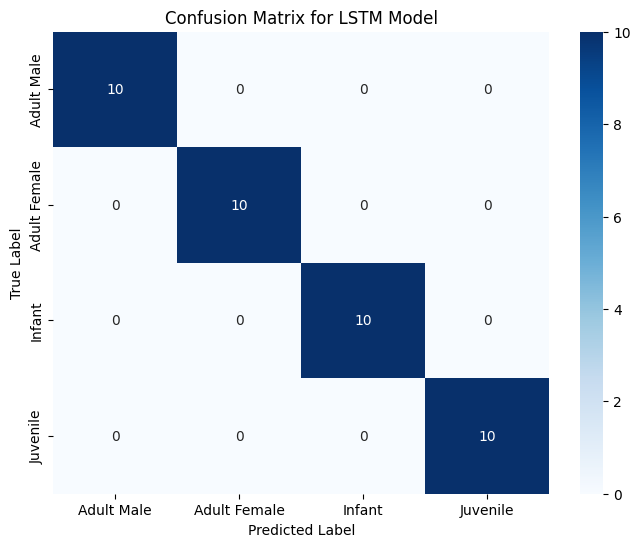

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_model2 = model2.predict(X_test)
y_pred_classes_model2 = np.argmax(y_pred_model2, axis=1)
y_true_classes_model2 = np.argmax(y_test, axis=1)

cm_model2 = confusion_matrix(y_true_classes_model2, y_pred_classes_model2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

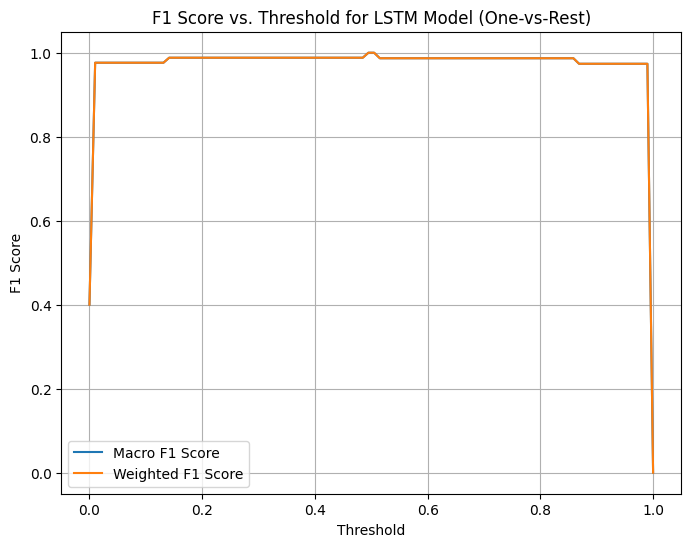

In [ ]:
# prompt: Generate the F1 score curve for this LSTM Model

import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Calculate F1 scores for different thresholds using a one-vs-rest approach
thresholds = np.linspace(0, 1, 100)
f1_scores_macro = []
f1_scores_weighted = []

# Binarize the true labels for one-vs-rest evaluation
y_true_binarized = label_binarize(y_true_classes_model2, classes=np.unique(y_true_classes_model2))
n_classes = y_true_binarized.shape[1]

for threshold in thresholds:
    y_pred_thresholded = (y_pred_model2 >= threshold).astype(int) # Apply threshold to all class probabilities

    # Calculate F1 score for each class (one-vs-rest) and average
    # Use zero_division=1 to avoid warnings/errors if no predictions or true labels for a class at a threshold
    f1_macro = f1_score(y_true_binarized, y_pred_thresholded, average='macro', zero_division=1)
    f1_weighted = f1_score(y_true_binarized, y_pred_thresholded, average='weighted', zero_division=1)

    f1_scores_macro.append(f1_macro)
    f1_scores_weighted.append(f1_weighted)


# Plot the F1 score curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores_macro, label='Macro F1 Score')
plt.plot(thresholds, f1_scores_weighted, label='Weighted F1 Score')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold for LSTM Model (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()

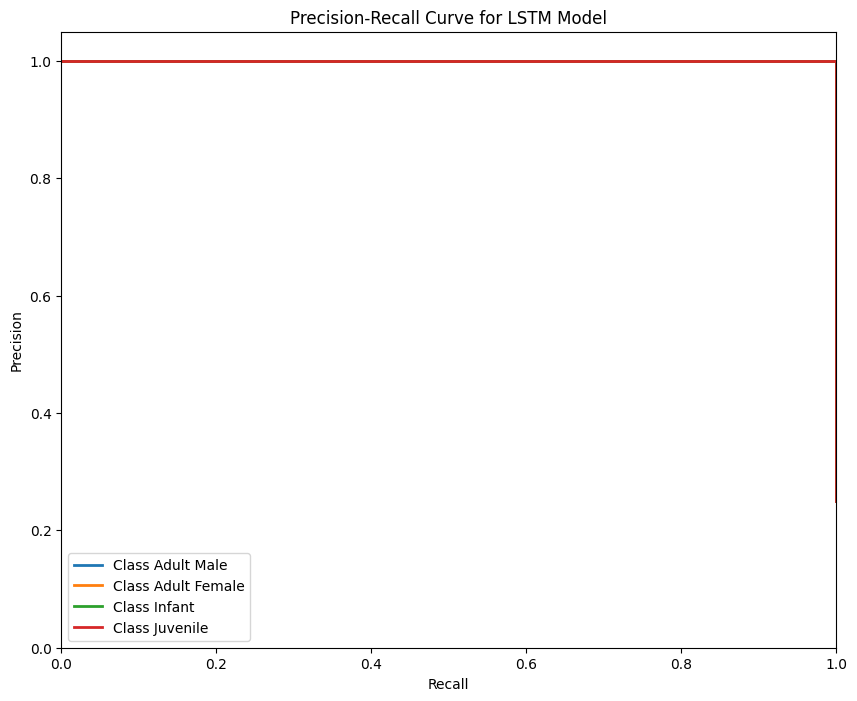

In [ ]:
# prompt: Generate the Precision curve for this LSTM Model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the true labels for plotting
y_test_binarized = label_binarize(y_true_classes_model2, classes=np.unique(y_true_classes_model2))
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(10, 8))

# For each class, plot precision-recall curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_model2[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for LSTM Model")
plt.legend(loc="best")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
# prompt: generate the validation and training curve for LSTM model

import matplotlib.pyplot as plt
# Generate the validation and training curve for LSTM model
history_lstm = model2.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_test, y_test))

# Get training and validation loss and accuracy from history
train_loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
train_accuracy_lstm = history_lstm.history['accuracy']
val_accuracy_lstm = history_lstm.history['val_accuracy']

# Plot training and validation loss for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(train_loss_lstm, label='LSTM Training Loss')
plt.plot(val_loss_lstm, label='LSTM Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_lstm, label='LSTM Training Accuracy')
plt.plot(val_accuracy_lstm, label='LSTM Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()